# Maneuver Recognition Package

# Content

**[1. About](#heading--1)**

**[2. Implementation: Real world vehicle maneuver recognition using smartphone sensors and LSTM models](#heading--2)**

  * [2.1. Project background](#heading--2-1)
  * [2.2. Dataset](#heading--2-2)
  * [2.3. Preprocessing](#heading--2-3)
      * [2.3.1. Windowing and Train- / Test-Splitting](#heading--2-3-1)
      * [2.3.2. Dropping maneuvers and balancing classes](#heading--2-3-2)
      * [2.3.3. Label encoding and variable transformation](#heading--2-3-3)
  * [2.4. Modelling](#heading--2-4)
    * [2.4.1. Defining model architecture and initializing the model](#heading--2-4-1)
    * [2.4.2. Training the model](#heading--2-4-2) 
  
  * [2.5. Evaluation](#heading--2-5)
    * [2.5.1. Validation accuracy and validation loss](#heading--2-5-1)
    * [2.5.2. Correlation matrix](#heading--2-5-2)
    * [2.5.3. Recall heatmap](#heading--2-5-3) 
    * [2.5.4. Precision heatmap](#heading--2-5-4) 

**[3. Documentation](#heading--3)**
   * [3.1. Preprocessing module](#heading--3-1)
      * [3.1.1. create_dataset()](#heading--3-1-1)
      * [3.1.2. timeseries_train_test_split()](#heading--3-1-2)
      * [3.1.3. remove_maneuvers()](#heading--3-1-3)
      * [3.1.4. LabelEncoding](#heading--3-1-4)
      * [3.1.5. transform_variables()](#heading--3-1-5)
   * [3.2. Modelling module](#heading--3-2)
      * [3.2.1. ManeuverModel](#heading--3-2-1)
      * [3.2.2. train()](#heading--3-2-2)
      * [3.2.3. test()](#heading--3-2-3)
      * [3.2.4. fit_model()](#heading--3-2-4)
   * [3.3. Evaluation module](#heading--3-3)
      * [3.3.1. relative_values()](#heading--3-3-1)
      * [3.3.2. plot_training_process()](#heading--3-3-2)
      * [3.3.3. create_heatmap()](#heading--3-3-3)
      * [3.3.4. confusion_heatmap()](#heading--3-3-4)
      * [3.3.5. precision_heatmap()](#heading--3-3-5)
      * [3.3.6. recall_heatmap()](#heading--3-3-6)

# About <a name="heading--1"/>

ManeuverRecognition is a python package which provides functions for the preprocessing of time series data, the creation of predictive LSTM based classification models and the evaluation of multi class predictions. In this repository its functionalities are demonstrated using a real world use case in the domain of vehicle telematics (section 2). Also the package documentation is provided (section 3).

A more detailed research paper is also available here: ManeuverRecognition - a python package for timeseries classification in the domain of vehicle telematics
*Abstract - In the domain of vehicle telematics the automated recognition of driving maneuvers is used to classify and evaluate driving behaviour and situations in traffic. This not only serves to enhance the personalization of insurance policies, but also to increase road safety, reduce accidents and the associated costs as well as to reduce fuel consumption and support environmentally friendly driving. In this context maneuver recognition technically requires a continuous application of time series classification which poses special challenges to the preprocessing of telematic sensor data, the training of predictive models, and the prediction itself. Although much research has been done in the field of gathering relevant data or the methods to build predictive models for the task of maneuver recognition, there is a need for python packages and functions that allow quickly transforming data into the required structure as well as to build and evaluate such models. The ManeuverRecognition package was therefore developed to provide the necessary functions for preprocessing, modelling and evaluation and also includes a ready to use LSTM based network structure that can be modified. The application of the package is demonstrated using real driving data of three different persons recorded via smartphone sensors.*

...

# Implementation: Real world vehicle maneuver recognition using smartphone sensors and LSTM models <a name="heading--2"/>

## Project background <a name="heading--2-1"/>

In this section, the implementation of the package is demonstrated using real world driving data of a previous research project which has been carried out at the Harz University of Applied Sciences. 

...

A more detailed description of the research project can be found in the corresponding paper.


## Dataset <a name="heading--2-2"/>
The dataset contains sensor data of a smartphones accelerometer, gyroscope and GPS which were recorded during a total of three trips driven by different persons using different vehicles on the same 60.7 kilometer route. The accelerometer was used to record the acceleration forces along three orthogonal axes in meters per square second without taking the gravitational force into account. The gyroscope was used to measure rotational speed around the same three axes in radians per second. GPS data includes latitude, longitude, altitude, accuracy as an estimated horizontal accuracy radius in meters, and speed in meters per second. The following picture shows the positioning of the smartphone during the recordings and the resulting alignment of the sensors axes.

![Sensor axes with positioning in vehicle](images/sensor_positioning.png)


The final dataset is composed of 19 variables which include smartphone data as well as manually assigned variables like the maneuver type, the route section, the road type, a unique maneuver ID, the vehicle and an ID for the person who was driving. In addition to the maneuver type there is also the variable maneuver element which represents a more refined category system. The variables of smartphone data include datetime, the accelerometer and gyroscope sensor variables per axes, as well as GPS information such as longitude, latitude, altitude, accuracy and speed.

In [498]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import torch
import torch.nn as nn

In [499]:
df = pd.read_csv("data/SensorRec_data_eng.csv")
df.head(5)

,datetime,accX,accY,accZ,gyroX,gyroY,gyroZ,latitude,longitude,altitude,accuracy,speed,maneuverID,maneuverType,maneuverElement,section,roadType,vehicle,person
0,2023-01-06 10:44:29.466,0.021387,-0.006456,-0.084595,-0.072036,-0.009720,-0.006924,52.366269,9.761421,98.700005,11.716,0.060892,000000-P1M,stationary,stationary,1,city_road,Skoda Fabia,P01
1,2023-01-06 10:44:29.958,0.023271,0.100068,0.143770,0.013182,0.004794,0.000399,52.366269,9.761421,98.700005,11.716,0.060892,000000-P1M,stationary,stationary,1,city_road,Skoda Fabia,P01
2,2023-01-06 10:44:30.456,0.030368,-0.006946,0.019102,0.000000,-0.001997,0.001198,52.366270,9.761421,98.700005,9.591,0.035770,000000-P1M,stationary,stationary,1,city_road,Skoda Fabia,P01
3,2023-01-06 10:44:30.957,0.012233,-0.005673,0.002899,0.000266,0.001198,0.001065,52.366270,9.761421,98.700005,9.591,0.035770,000000-P1M,stationary,stationary,1,city_road,Skoda Fabia,P01
4,2023-01-06 10:44:31.456,0.017861,0.001417,0.017249,-0.001332,-0.002397,0.000399,52.366270,9.761421,98.700005,9.591,0.035770,000000-P1M,stationary,stationary,1,city_road,Skoda Fabia,P01


For this demonstration of the package the accelerometer and gyroscope variables as well as the GPS speed and the road type will be used to predict the maneuver type. Although the road type was also manually labeled it can be used since the road type of new driving data could be accessed by matching the GPS coordinates with publicly available road data. In order to use the categorical variable road type it will first be converted into dummy variables. To prevent mixing the data of the three different persons when executing a rolling windowing function in the preprocessing the data of the three persons will be split and recombined afterwards.

In [501]:
df = pd.get_dummies(data=df, columns=['roadType'])
df_p1 = df.loc[df['person'] == 'P01', :]
df_p2 = df.loc[df['person'] == 'P02', :]
df_p3 = df.loc[df['person'] == 'P03', :]

dataframe_list = [df_p1, df_p2, df_p3]

## Preprocessing <a name="heading--2-3"/>

### Windowing and Train-/Test-Splitting <a name="heading--2-3-1"/>

Our goal is to create a model which can correctly identify driving maneuvers in unknown data of future driving records. Therefore, to train the model, we cannot simply use the individual maneuvers already assigned to their IDs, but have to use a rolling window to create training and testing cases.

In order to do that, we are in need of two specific functions:
1. A windowing function that gets our data and returns windows with a specific amount of time steps and a specific step size between those windows in the shape of (cases, timesteps, variables).
2. A function to split the data into training and testing data before the windowing is applied. If we do not split training and testing data before using the windowing function, there will be data leakage because overlapping windows may end up in both partitions.

For this purpose we can use the timeseries_train_test_split function in the preprocessing module. It first splits the given dataframe in an arbitrary number of partitions. Then it randomly selects some of these partitions in regard to our test size and removes them from a copy of the full dataframe. The remaining data will be used for training. We can also use this function to apply a robust scaling which will use the training data for fitting the scaler. The windowing function will then be applied on the training and testing partitions separately.

With this approach, it can still happen occasionally that we create unnatural transitions between maneuvers that occurred before and after the partitions we cut out for the test data or that we break some maneuvers. However, the amount of it which depends on the number of splits we use will be negligible, as it is clearly more important that we have absolutely no data leakage. 

The following parameters can be configured:
- splits: Number of random partitions in which data will be separated before windowing will be applied.
- test_size: Proportion of data to use for testing.
- time_steps: Length of windows in number of rows.
- step_size: Steps between windows in number of rows.
- scale: Bool whether we apply robust scaling or not.

Since we have data of three different persons and to ensure that different route segments of the trips can appear in the training and test data we will apply the timeseries_train_test_split function on each individual dataset and combine the windowed data subsequently. Our windows will have a length of 14 timesteps which is 7 seconds in our dataset and we will use a stepsize of 6 timesteps which equals 3 seconds. We then merge the data, with every window seperated and already in the right shape.

In [502]:
from maneuver_recognition import preprocessing

x_vars = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'speed', 'roadType_autobahn',
          'roadType_city_road','roadType_country_road','roadType_federal_highway']
y_var = 'maneuverType'
splits = 20
test_size = 0.2
time_steps = 14
step_size = 6

X_train, y_train, X_test, y_test = [], [], [], []
for df in dataframe_list:
    X_train_df, y_train_df, X_test_df, y_test_df = preprocessing.timeseries_train_test_split(df, x_variables=x_vars,
                y_variable=y_var, splits=splits, test_size=test_size,time_steps=time_steps, step_size=step_size, scale=True)

    
    X_train.append(X_train_df)
    y_train.append(y_train_df)
    X_test.append(X_test_df)
    y_test.append(y_test_df)
    
X_train, y_train, X_test, y_test = np.vstack(X_train), np.vstack(y_train), np.vstack(X_test), np.vstack(y_test)

Using this function will result in having our train and test data partitions in a shape of (cases, timesteps, variables) for x and (cases, label) for y.

In [503]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3833, 14, 11), (936, 14, 11), (3833, 1), (936, 1))

### Dropping maneuvers and balancing classes <a name="heading--2-3-2"/>

To examine how many individual driving maneuvers were recorded per maneuver type, the following plot can be considered. It turns out that some maneuvers, such as overtaking or crossing an intersection, occurred in too few cases overall. Therefore these maneuvers should be excluded. By using preprocessing.remove_maneuvers we can drop maneuvers completely or apply undersampling to balance the class distributions within both our test and training data.

In [504]:
fig = go.Figure(data=[
    go.Bar(name='Training data', x=np.unique(y_train), y=np.unique(y_train, return_counts=True)[1]),
    go.Bar(name='Test data', x=np.unique(y_test), y=np.unique(y_test, return_counts=True)[1])
])

fig.update_layout(barmode='stack', title="Amount of windows per maneuver type in the train and test data")
fig.update_xaxes(title_text='maneuver')
fig.update_yaxes(title_text='Amount')
fig.show()

In [505]:
drop_maneuvers = ['acceleration_lane', 'overtaking', 'deceleration_lane', 'crossing_roundabout', 'crossing_intersection']


X_train, y_train, X_test, y_test = preprocessing.remove_maneuvers(X_train, y_train, X_test, y_test, drop_maneuvers)
X_train, y_train, X_test, y_test = preprocessing.remove_maneuvers(X_train, y_train, X_test, y_test, 
                                                                  'continuous_driving', 0.9)
X_train, y_train, X_test, y_test = preprocessing.remove_maneuvers(X_train, y_train, X_test, y_test, 
                                                                      'stationary', 0.8)

Let's have another look at the amount of windows in our new training and testing partitions. There will still be slight imbalance between our maneuver classes, but now the data set is much better suited for training and testing our model and since we are dealing with real world data it is fine not to synthetically bring the data to an absolute balanced ratio.


In [506]:
fig = go.Figure(data=[
    go.Bar(name='Training data', x=np.unique(y_train), y=np.unique(y_train, return_counts=True)[1],
           text=np.unique(y_train, return_counts=True)[1], textposition='auto'),
    go.Bar(name='Test data', x=np.unique(y_test), y=np.unique(y_test, return_counts=True)[1],
           text=np.unique(y_test, return_counts=True)[1], textposition='auto')
])

fig.update_layout(barmode='stack', title="Amount of windows per maneuver type in the train and test data")
fig.update_xaxes(title_text='maneuver')
fig.update_yaxes(title_text='Amount')
fig.show()

### Label encoding and variable transformation <a name="heading--2-3-3"/>

Now we have to create a label encoder so that we can extract the correct labels of the predictions later. The last step is to turn our training and testing data into the format of a PyTorch variable.

In [507]:
encoding = preprocessing.LabelEncoding(y_train, y_test)
y_train, y_test = encoding.transform()

In [508]:
X_train, y_train, X_test, y_test = preprocessing.transform_variables(X_train, y_train, X_test, y_test)

## Modelling <a name="heading--2-4"/>
Before using the modelling module of the maneuver recognition package, we can set the device to use for training and testing our model.

In [509]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### Defining model architecture and initializing the model <a name="heading--2-4-1"/>
The modelling module can then be used to create and use a pytorch LSTM model. The base structure of the model is already defined and consists of a LSTM layer, two linear fully connected layers with a dropout of 0.3 and a final linear layer for multi class classification. Different configurations have been tested for this use case, but with the following parameters the architecture of the model can be configured individually:
- hidden_size: The number of features in the hidden state.
- lstm_layers: Number of stacked LSTM layers.
- lstm_dropout: Rate of applied dropout in LSTM layers.


In [510]:
from maneuver_recognition import modelling

number_of_features = X_train.shape[2]
number_of_classes = len(np.unique(y_train))
hidden_size = 24
lstm_layers = 2
lstm_dropout = 0.7

model     = modelling.ManeuverModel(number_of_features, number_of_classes, hidden_size, lstm_layers, lstm_dropout).to(device)

print(model)

ManeuverModel(
  (lstm): LSTM(11, 24, num_layers=2, batch_first=True, dropout=0.7)
  (full_layer1): Linear(in_features=24, out_features=64, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (full_layer2): Linear(in_features=64, out_features=32, bias=True)
  (classifier): Linear(in_features=32, out_features=8, bias=True)
)


### Training the model <a name="heading--2-4-2"/>

Now we can use the function train_maneuver_model to fit the model. The function uses PyTorch's DataLoader wrapper, so we can directly input our training and testing data and define a specific batch_size. We also have to set the number of epochs and define an optimizer as well as the type of loss function to use for the training process. The fit function is not part of the model class in order to enable independent use of the function with other models and model structures.

In [511]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()

loss_list, accuracy_list = modelling.fit_model(model, X_train, y_train, X_test, y_test, epochs=80,
                                         batch_size=128, loss_function=loss_fn, optimizer=optimizer,
                                         device=device)

Epoch 1 / 80
-------------------------------
Test Error: Accuracy: 18.9%, Avg loss: 2.066377 

Epoch 2 / 80
-------------------------------
Test Error: Accuracy: 18.9%, Avg loss: 2.046679 

Epoch 3 / 80
-------------------------------
Test Error: Accuracy: 36.1%, Avg loss: 2.015119 

Epoch 4 / 80
-------------------------------
Test Error: Accuracy: 30.4%, Avg loss: 1.950466 

Epoch 5 / 80
-------------------------------
Test Error: Accuracy: 32.9%, Avg loss: 1.820074 

Epoch 6 / 80
-------------------------------
Test Error: Accuracy: 45.0%, Avg loss: 1.637263 

Epoch 7 / 80
-------------------------------
Test Error: Accuracy: 46.1%, Avg loss: 1.483204 

Epoch 8 / 80
-------------------------------
Test Error: Accuracy: 48.9%, Avg loss: 1.375482 

Epoch 9 / 80
-------------------------------
Test Error: Accuracy: 49.6%, Avg loss: 1.269373 

Epoch 10 / 80
-------------------------------
Test Error: Accuracy: 52.5%, Avg loss: 1.189174 

Epoch 11 / 80
-------------------------------
Tes

## Evaluation <a name="heading--2-5"/>

### Validation accuracy and validation loss <a name="heading--2-5-1"/>

By using the plot_training_process function of the evaluation module, the validation loss and validation accuracy per epoch can be visualized to examine the training process and assess whether the training has led to over or underfitting.

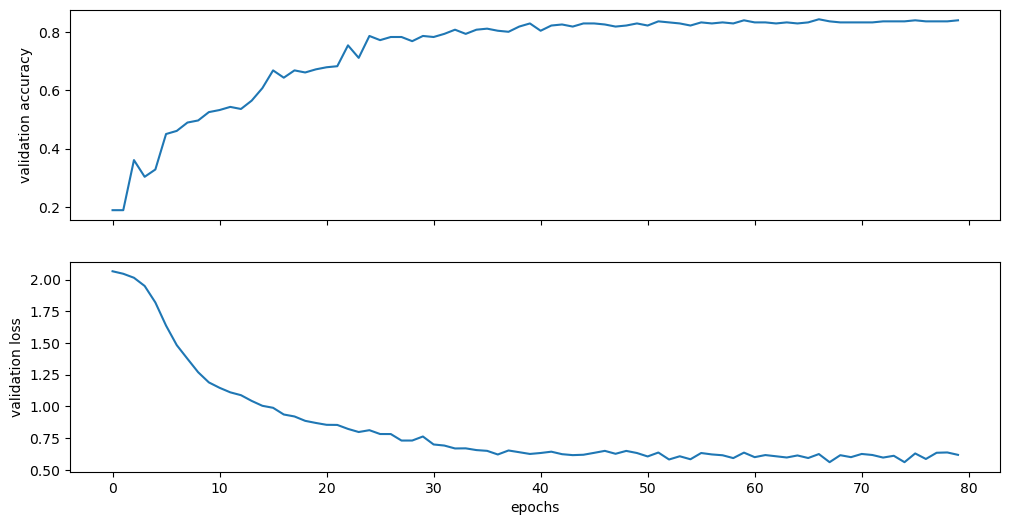

In [512]:
from maneuver_recognition import evaluation
evaluation.plot_training_process(loss_list, accuracy_list)

### Correlation matrix <a name="heading--2-5-2"/>
In order to evaluate the performance of our model, we can use the function predict() from the modelling module with our test data and then compare the predicted with the actual values. The already created encoding object which inherits the label_encoder can be used to access the perviously encoded class labels and apply the inverse_transform() function of the label_encoder to turn the y values into the original class labels for comparison. With these class labels and the inverse transformed y_test and y_pred data we can use the confusion_heatmap() function of the evaluation module to plot the comparison of actual and predicted values.

Since we have an unbalanced multi-class use case, and the color intensity of this regular heatmap takes all fields into account, the distribution should instead be inspected row or column wise which can be done by using the recall_heatmap (row wise) or precision_heatmap (column wise) functions. In this way we can inspect the proportion of correctly classified values for each class separately in regard to whether a specific class was predicted (precision_heatmap) or a case of a specific class is given (recall_heatmap).

In [513]:
#y_pred = modelling.predict(X_test, model)
y_pred = model.predict(X_test)

# Inverse transform the encoded y
y_test_inverse = encoding.label_encoder.inverse_transform(y_test)
y_pred_inverse = encoding.label_encoder.inverse_transform(y_pred)
#classes = encoding.label_encoder.classes_
classes = encoding.encoded_labels
#
fig = evaluation.confusion_heatmap(y_test, y_pred, classes)
fig.show()

### Recall heatmap <a name="heading--2-5-3"/>

The recall_heatmap function can be used to inspect the proportion of correctly classified cases per actually given class. This will make the diagonal of the heatmap represent a recall value for each class. The heatmap can be read as follows: Given an actual case of a class the row values show the proportion of predicted classes.

In [514]:
fig = evaluation.recall_heatmap(y_test, y_pred, classes)
fig.show()

### Precision heatmap <a name="heading--2-5-4"/>

The precision_heatmap function can be used to inspect the proportion of correctly classified cases per predicted class. This will make the diagonal of the heatmap represent a precision value for each class. The heatmap can be read as follows: Given cases are predicted to be from a specific class the column values show the proportion of actual class values per class.


In [515]:
fig = evaluation.precision_heatmap(y_test, y_pred, classes)
fig.show()

# Documentation <a name="heading--3"/>

## Preprocessing module <a name="heading--3-1"/>

The preprocessing module provides functionalities to transform data into the required structure of time series classification and the usage of recurrent networks.

### create_dataset() <a name="heading--3-1-1"/>
Function to split data with a categorical y variable into windows with length of given time_steps and an interval equal to value of step between the windows. For overlapping windows use a value for step smaller than time_steps.

Parameters:
- **X**: DataFrame with data of predictors.
- **y**: DataFrame column of target variable.
- **time_steps**: int - Length of windows in number of rows.
- **step_size**: int - Steps between windows. (int)

Returns: Tuple of numpy array for x-variable data and numpy array for y-variable data



### timeseries_train_test_split() <a name="heading--3-1-2"/>

Function to split a timeseries into windowed training and testing data without having data leakage even if using overlapping windows.

Parameters:
- **data**: DataFrame with x and y variables.
- **x_variables**: List of column names of predictor variables.
- **y_variable**: str - Column name of target variable.
- **splits**: int - Number of random partitions in which data will be separated before windowing will be applied.
- **test_size**: float - Proportion of data to use for testing.
- **time_steps**: int - Length of windows in number of rows.
- **step_size**: int - Steps between windows.
- **scale**: bool - default = False, Apply robust scaling.

Returns: Tuple of np.ndarrays - Windowed arrays for training and testing data of predictors and target variable.


### remove_maneuvers() <a name="heading--3-1-3"/>

Function to remove maneuvers from given data partitions in a given proportion to balance maneuver classes.

Parameters:
- **X_train**: X data of training partition.
- **y_train**: Target variable data of training partition.
- **X_test**: X data of testing partition.
- **y_test**: Target variable data of testing partition.
- **maneuvers**: List[str] - List of maneuver names or single maneuver name.
- **proportion_to_remove**: float - default = 1.0, Proportion of data to remove for given maneuvers.

Returns: Numpy arrays of X and y data for training and testing partitions.


### LabelEncoding <a name="heading--3-1-4"/>
Class to encode labels from target variable data and transform given data with sklearn LabelEncoder. Stores LabelEncoder for usage of inverse_transform().

Init-Parameters:
- **y_train**: Target variable data of training partition.
- **y_test**: Target variable data of testing partition.

Function transform():
No parameters. Returns: Transformed numpy arrays of training and testing target variable data.
    


### transform_variables() <a name="heading--3-1-5"/>
Function to transform numpy arrays of training and testing data to torch Variables.

Parameters:
- **X_train**: Numpy array of training predictor data.
- **y_train**: Numpy array of training target variable data.
- **X_test**: Numpy array of testing predictor data.
- **y_test**: Numpy array of training target variable data.
    
Returns: Data of type torch.Tensor for all training and testing partitions.


## Modelling module <a name="heading--3-2"/>

The modelling module includes a LSTM model structure that can be trained and used for the purpose of time series classification. The basic structure is predefined, but can be customized via various parameters.

### ManeuverModel <a name="heading--3-2-1"/>
Class with LSTM based model architecture for maneuver recognition.

Init-Parameters:
- **n_features**: int - The number of expected features in the input (number of X variables).
- **n_classes**: int - Number of classes for classification layer.
- **n_hidden**: int - default = 24, number of features in the hidden state from the last LSTM layer to the first fully connected linear layer.
- **n_layers**: int - default = 4, number of stacked LSTM layers.
- **lstm_dropout**: float - default = 0.7, value of applied dropout in LSTM layers.
- **n_features_linear1**: int - default = 64, number of features in first linear layer.
- **n_features_linear2**: int - default = 32, number of features in second linear layer.
- **linear_dropout**: float - default = 0.3, value of applied dropout between first and second linear layer.

Function predict():
Function to use model for prediction of given cases.

Parameters:
- **X**: X data to use for prediction.

Returns: List of predictions for given input data.

### train() <a name="heading--3-2-2"/>
Function to apply training process on model with given data of dataloader object. In order to fit the model with direct data use train_maneuver_model.

Parameters:
- **dataloader**: Dataloader object for training data.
- **model**: Model object.
- **loss_fn**: Loss function.
- **optimizer**: Optimizer object for optimization algorithm.
- **device**: Device to use.

### test() <a name="heading--3-2-3"/>
Function to evaluate given model with data of dataloader. In order to use the model for predictions use the predict function of the model object instead.

Parameters:
- **dataloader**: Dataloader object for test data.
- **model**: Model object.
- **loss_fn**: Loss function.
- **device**: Device to use.
- 
Returns: Tuple with proportion of correctly predicted cases and average test loss.

### fit_model() <a name="heading--3-2-4"/>
Function to fit a model. Applies model training with given X and y training data and uses given X and y test data for training validation. Returns list of validation loss and validation accuracy per epoch.

Parameters:
- **model**: Model object
- **X_train**: X data of training partition.
- **y_train**: Target variable data of training partition.
- **X_test**: X data of testing partition.
- **y_test**: Target variable data of testing partition.
- **epochs**: Number of epochs in training process.
- **batch_size**: Batch size to use for training and testing.
- **loss_function**: Loss function.
- **optimizer**: Optimizer object for optimization algorithm.
- **device**: Device to use.

Returns: List of validation loss and validation accuracy values for every epoch.

## Evaluation module <a name="heading--3-3"/>

The evaluation module provides functions to examine the training process by visualizing validation accuracy and validation loss and to evaluate the model quality by comparing actual and predicted classes for testing data. With the precision_heatmap() and the recall_heatmap() functions the proportion of correctly classified values for each class can be inspected separately in regard to whether a specific actual class is given or a specific class was predicted.

### relative_values() <a name="heading--3-3-1"/>
Function to calculate values relative to sum of array.

Parameters:
- **array**: Input numpy array.

Returns: Numpy array with values divided by sum of input array.

### plot_training_process() <a name="heading--3-3-2"/>
Function to plot validation accuracy and validation loss over epochs.

- **loss_list**: List of validation loss by epoch.
- **accuracy_list**: List of validation loss by epoch.
- **figsize**: Tuple - default = (12,6), values of figure size.
 

### create_heatmap() <a name="heading--3-3-3"/>
Function to create a heatmap plot of given data and class labels.

Parameters:
- **data**: Heatmap values.
- **classes**: Class labels.
- **colorscale**: Plotly continuous colorscale.
- **title**: str - Figure title.
- **height**: int - Figure height.
- **width**: width - Figure width.
    
Returns: Plotly figure.


### confusion_heatmap() <a name="heading--3-3-4"/>
Function to create heatmap plot based on confusion matrix of predicted and true values for arbitrary number of classes. Uses create_heatmap() function for plot generation.

Parameters:
- **y_test**: Actual class values of test data.
- **y_pred**: Predicted class values of test data.
- **classes**: Class labels.
- **colorscale**: default = 'Blues', plotly colorscale.
- **height**: int - default = 900, figure height.
- **width**: int - default = 900, figure width.
- **title**: str - default = 'Confusion heatmap', figure title.

Returns: Plotly figure.

### precision_heatmap() <a name="heading--3-3-5"/>
Function to create a heatmap plot based on confusion matrix of predicted and true values with relative values along axis of each predicted class (column wise). This represents a precision value for each class in the diagonal of the heatmap. Uses create_heatmap() function for plot generation.

Parameters:
- **y_test**: Actual class values of test data.
- **y_pred**: Predicted class values of test data.
- **classes**: Class labels.
- **colorscale**: default = 'Blues', plotly colorscale.
- **height**: int - default = 900, figure height.
- **width**: int - default = 900, figure width.
- **title**: str - default = 'Precision heatmap (column wise relative values)', figure title.
    
Returns: Plotly figure.
    

### recall_heatmap() <a name="heading--3-3-6"/>
Function to create a heatmap plot based on confusion matrix of predicted and true values with relative values along axis of each
    predicted class (row wise). This represents a recall value for each class in the diagonal of the heatmap. Uses create_heatmap() function for plot generation.

Parameters:
- **y_test**: Actual class values of test data.
- **y_pred**: Predicted class values of test data.
- **classes**: Class labels.
- **colorscale**: default = 'Blues', plotly colorscale.
- **height**: int - default = 900, figure height.
- **width**: int - default = 900, figure width.
- **title**: str - default = 'Recall heatmap (row wise relative values)', figure title.
    
Returns: Plotly figure.
